In [36]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_openai langchain_experimental pinecone pypdf langchain-huggingface

In [37]:
import os
from dotenv import load_dotenv

In [38]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph_multi_agent_demo"

### Setup API Keys

In [39]:
# Load environment variables from .env file located at a specific path
load_dotenv(dotenv_path='../.env')

def _set_env():
    print("LANGCHAIN_ENDPOINT:", os.environ["LANGCHAIN_ENDPOINT"])

_set_env()

LANGCHAIN_ENDPOINT: https://api.smith.langchain.com


### Creating LLM

In [40]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.0)

### Websearch Tool

In [41]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=2)

### RAG tool

In [42]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List
from langchain_core.documents import Document
import os

def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "../content/docs"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

Loaded 7 documents from the folder.


In [43]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

pages = text_splitter.split_documents(documents)
print(f"Split the documents into {len(pages)} chunks.")

Split the documents into 19 chunks.


In [45]:

from langchain_community.vectorstores import Pinecone as PineconeStore
from langchain_openai import OpenAIEmbeddings
import pinecone

PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY')

PINECONE_INDEX_NAME="rag-wm-idx"

embeddings_model = OpenAIEmbeddings(
                                    openai_api_key=os.environ.get('OPENAI_API_KEY'),
                                    deployment="text-embedding-3-small",
                                    model="text-embedding-3-small", 
                                    chunk_size=16, 
                                    request_timeout=30,
                                    max_retries=3)

pc = pinecone.Pinecone(api_key=PINECONE_API_KEY)     
index = pc.Index(PINECONE_INDEX_NAME)

In [46]:

def embed_and_store(pages, embeddings_model):
    # Embedding the documents and storing them in Pinecone
    vectorstore = PineconeStore.from_documents(pages, 
                                    embedding=embeddings_model,
                                    index_name=PINECONE_INDEX_NAME)
    return vectorstore

vectorstore = embed_and_store(pages, embeddings_model)

In [47]:
def return_store_retriever(vectordb):
    return vectordb.as_retriever(search_type="mmr",
                                search_kwargs={'k': 5, 
                                               'fetch_k': 50,
                                               'lambda_mult': 0.75})

retriever = return_store_retriever(vectorstore)

from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_chroma import Chroma

collection_name = "my_collection"
vectorstore = Chroma.from_documents(
    collection_name=collection_name,
    documents=pages,
    embedding=embedding_function,
    persist_directory="./chroma_db"
)
print("Vector store created and persisted to './chroma_db'")

In [48]:
retriever_results = retriever.invoke("What are FITGMR 5 pillars?")
print(retriever_results)

[Document(metadata={'page': 4.0, 'page_label': '5', 'source': '../content/docs/FITGMR Case Study.pdf'}, page_content="August 2022          \n \n \nAdditional Information About FITGMR  \nThe FITGMR mobile app is supported by the Team Dashboard, a web app which tracks the \nperformance of gamers on a team. The Team Dashboard allows coaches and managers to have a \nwindow into their players health, enabling them to intervene, encourage and create accountability for \nplayers' performance in the 5 Pillars of the Health. It is also a useful tool for evaluating Game \nReadiness by player.  \nWe will also be launching in September 2022 the FITGMR Training Program. An online learning \nmanagement system where coaches, educators, gamers, managers and parents can learn about \nwhy performance matters in esports and receive a completion certificate. Course topics include each \nof the FITGMR 5 Pillars of Health, FITGMR Foundation of Character and the Pepperdine University \nBeyond the Game Mentor

In [49]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
  """Tool to Retrieve Semantically Similar documents to answer User Questions related to WM AI"""
  print("INSIDE RETRIEVER NODE")
  retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
  retriever_result = retriever.invoke(question)
  return "\n\n".join(doc.page_content for doc in retriever_results)

### NL2SQL Tool

In [50]:
from langchain_community.utilities import SQLDatabase

# Replace with your actual PostgreSQL connection details
connection_uri = (
    f"postgresql://{os.environ['POSTGRES_USER']}:"
    f"{os.environ['POSTGRES_PASSWORD']}@"
    f"{os.environ['POSTGRES_HOST']}:"
    f"{os.environ['POSTGRES_PORT']}/"
    f"{os.environ['POSTGRES_DB']}?options=-csearch_path=wealth_management"
)

# Include the schema in the search path
db = SQLDatabase.from_uri(connection_uri)

# Print database dialect
print(db.dialect)

# Print usable table names
print(db.get_usable_table_names())

# Example query
result = db.run("SELECT * FROM client LIMIT 10;")
print(result)


postgresql
['client', 'customer', 'estate_planning', 'financial_status', 'goals', 'insurance', 'liabilities', 'lifestyle', 'market_views', 'ml_insights', 'portfolio', 'tax_profile']
[(1, 'Michelle Parsons', datetime.date(1979, 4, 9), 'French Southern Territories', 'Canada', 'Holiday representative', Decimal('608665.51'), 'Taylor-Martinez', 'Finance', 'Widowed', 4, '[{"relation": "Child", "age": 24}, {"relation": "Parent", "age": 11}]', 'Aggressive', 'Novice', Decimal('2356532.68'), 'PhD', 'Mandarin', '{"investment_restrictions": "None", "communication_style": "Casual"}'), (2, 'Julian Mays', datetime.date(1993, 10, 3), 'Korea', 'Monaco', 'Outdoor activities/education manager', Decimal('334239.98'), 'Martin PLC', 'Real Estate', 'Widowed', 6, '[{"relation": "Parent", "age": 5}]', 'Conservative', 'Intermediate', Decimal('1104055.05'), 'PhD', 'French', '{"investment_restrictions": "ESG-focused", "communication_style": "Casual"}'), (3, 'Harold Mccormick', datetime.date(1970, 12, 1), 'Grenada

In [51]:
#!wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite

In [21]:
#!mv Chinook_Sqlite.sqlite Chinook.db

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
#from langchain_community.utilities import SQLDatabase

#db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [52]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text

In [53]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_tool(question):
  """Tool to Generate and Execute SQL Query to answer User Questions related to DB"""
  print("INSIDE NL2SQL TOOL")
  execute_query = QuerySQLDataBaseTool(db=db)
  write_query = create_sql_query_chain(llm, db)

  chain = (
      RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
          result=itemgetter("query") | execute_query
      )
  )

  response = chain.invoke({"question": question})
  return response['result']

question = "Tell me networth of Julian?"
result = nl2sql_tool.invoke({"question": question})
print(f"Question: {question}")
print(f"Answer: {result}")

INSIDE NL2SQL TOOL
Question: Tell me networth of Julian?
Answer: [(Decimal('1104055.05'),)]


### Create Supervisor Agent

In [54]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command


members = ["web_researcher", "investment_analyst", "sql_agent"]
# Our supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt_old = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. Also, summarize it after "
    " review if answer looks fine, but do not hallucinate. When finished,"
    " respond with FINISH."
)

system_prompt="""You are a supervisor tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. Each worker will perform a task and respond 
with their results and status. If the conversation is over, respond with 'FINISH'.
    - **investment_analyst**: Use this worker for tasks that involve:
        - Analyzing financial reports and wealth management (private and public) research reports.
        - Comparing revenue growth, profit margins, or similar financial metrics for any particular company or industry.
        - Addressing questions related to c Performance & Strategic Direction.
        - Analyzing tax laws, regulations, and policies.
        - Analyzing Analyst Ratings & Investment Thesis and Analyst Recommendations.
        - General analytical tasks that require insights from unstructured data, trends, or strategic analysis.
    - **sql_agent**: Use this worker for tasks that involve:
        - Answering questions related to customer or client data.
        - Answering questions client's portfolio performance.
        - Answering questions for clients goals, insurance, liabilities, lifestyle, estate planning.
        - Handling queries that require specific data analysis, calculations, or retrieval from structured SQL databases, 
        particularly when it involves client segmentation, types of portfolios, distribution of products or volume metrics.
     - **web_researcher**: Use this worker for tasks that involve:
        - Answering questions when answers from **investment_analyst** are not relevant or not available.
        - Answering questions when latest rates are needed for any calculation.
        - Answering questions when latest news is needed to provide context, and to make sure investment decisions are based on current market conditions.
Decision Criteria:
- If the query mentions analyzing tax rules, policies etc., or refering to available trading, investment data, or in general information, route it to the **investment_analyst**.
- If the query involves structured data points related to clients portfolio, their investment, or any other personal data or fund performance, which 
requires a calculation or database lookup, direct it to the **sql_agent**.
- In cases where both agents could be relevant, prioritize the **investment_analyst** for tax rules, product data and the **sql_agent** for client specific analytics.
Example Decision Flow:
- Query: "Based on past performance of different companies on share market, which one is best suited for specific client who is more conservative." -> **investment_analyst**
- Query: "What are the top 3 clients with highest net worth?" -> **sql_agent**
- Query: "Analyze the latest Ontario tax rules and investment products." -> **investment_analyst**
- Query: "Analyze current market conditions to come up with best investment strategy for specific client based on their portfolio" -> **web_researcher**
"""


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["web_researcher", "investment_analyst", "sql_agent","FINISH"]


def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "investment_analyst", "sql_agent", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END

    return Command(goto=goto)

### Create Web Research, Investment Analyst (RAG) and Sql Agent

In [55]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

In [56]:
from typing import Callable, Literal, Optional, Sequence, Type, TypeVar, Union, cast
from langchain_core.language_models import BaseChatModel, LanguageModelLike
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langchain_core.runnables import (
    Runnable,
    RunnableBinding,
    RunnableConfig,
)
from langchain_core.tools import BaseTool
from typing_extensions import Annotated, TypedDict
from langgraph._api.deprecation import deprecated_parameter
from langgraph.errors import ErrorCode, create_error_message
from langgraph.graph import StateGraph
from langgraph.graph.graph import CompiledGraph
from langgraph.graph.message import add_messages
from langgraph.managed import IsLastStep, RemainingSteps
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.store.base import BaseStore
from langgraph.types import Checkpointer
from langgraph.utils.runnable import RunnableCallable

class AgentState(TypedDict):
    """The state of the agent."""

    messages: Annotated[Sequence[BaseMessage], add_messages]

def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
      return {"messages": [llm_with_tools.invoke(state["messages"])]}
    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    # Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    graph = graph_builder.compile()
    return graph

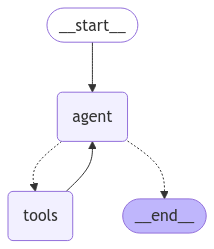

In [57]:
websearch_agent = create_agent(llm, [web_search_tool])

from IPython.display import Image, display

try:
    display(Image(websearch_agent.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [58]:
def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )

In [59]:
result = websearch_agent.invoke({"messages": [("user", "what are the 2024 personal tax slabs in ontario?")]})

In [60]:
result['messages'][-1].content

'The personal tax slabs for Ontario in 2024 are as follows:\n\n1. **8.79%** on the portion of taxable income that is **$30,507 or less**.\n2. **14.95%** on the portion of taxable income over **$30,507 up to $61,015**.\n3. **17.91%** on the portion of taxable income over **$61,015 up to $100,000**.\n4. **19.16%** on the portion of taxable income over **$100,000 up to $150,000**.\n5. **20.53%** on the portion of taxable income over **$150,000**.\n\nFor more detailed information, you can refer to the following sources:\n- [Canada Revenue Agency](https://www.canada.ca/en/revenue-agency/services/tax/individuals/frequently-asked-questions-individuals/canadian-income-tax-rates-individuals-current-previous-years.html)\n- [TaxTips.ca](https://www.taxtips.ca/taxrates/on.htm)'

In [61]:
rag_agent = create_agent(llm, [retriever_tool])

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="investment_analyst")
            ]
        },
        goto="supervisor",
    )

In [62]:
nl2sql_agent = create_agent(llm, [nl2sql_tool])

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="sql_agent")
            ]
        },
        goto="supervisor",
    )

In [63]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("investment_analyst", rag_node)
builder.add_node("sql_agent", nl2sql_node)
graph = builder.compile()

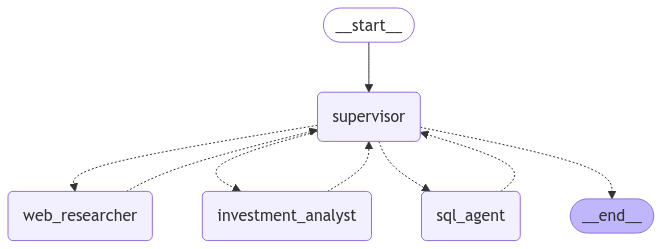

In [64]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [65]:
for s in graph.stream(
    {"messages": [("user", "What are wealth management basic principles?")]}, subgraphs=True
):
    print(s)
    print("----")

Next Worker: web_researcher
((), {'supervisor': None})
----
(('web_researcher:f99aedb9-8b15-3b41-4404-d8dc18e5121e',), {'agent': {'messages': [AIMessage(content="Wealth management involves a comprehensive approach to managing an individual's or family's financial resources. Here are some basic principles of wealth management:\n\n1. **Goal Setting**: Establish clear, measurable, and achievable financial goals. This includes short-term, medium-term, and long-term objectives.\n\n2. **Asset Allocation**: Diversify investments across various asset classes (stocks, bonds, real estate, etc.) to balance risk and return according to the investor's risk tolerance and time horizon.\n\n3. **Risk Management**: Identify and assess risks associated with investments and financial decisions. Implement strategies to mitigate these risks, such as insurance and diversification.\n\n4. **Tax Efficiency**: Understand the tax implications of investment decisions and seek strategies to minimize tax liabilities

In [66]:
input_question = "What FITGMR is offering and then do a web research on it"

for s in graph.stream(
    {"messages": [("user", input_question)]}, subgraphs=True
):
    print(s)
    print("----")

Next Worker: web_researcher
((), {'supervisor': None})
----
(('web_researcher:bd61a7ab-e7bf-53eb-7c7e-67cc0856f4c0',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rCOhLpe3Lm5uBAKENMQYhcJ7', 'function': {'arguments': '{"query":"FITGMR offerings"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 93, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2530b9cb-4a9a-44b3-b4d6-8712f17a69de-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'FITGMR offerings'}, 'id': 'call_rCOhLpe3Lm5uBAKENMQYhcJ7', 'type': '

In [67]:
input_question = "how many clients have more than 20k cashflow surplus and how can they invest better?"

for s in graph.stream(
    {"messages": [("user", input_question)]}, subgraphs=True
):
    print(s)
    print("----")

Next Worker: sql_agent
((), {'supervisor': None})
----
INSIDE NL2SQL TOOL
INSIDE NL2SQL TOOL
(('sql_agent:c8e2897a-406f-cf5c-c58b-91336a7b69bc',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BwK624tdNcI4i7E3pxchqyNt', 'function': {'arguments': '{"question": "How many clients have more than 20k cashflow surplus?"}', 'name': 'nl2sql_tool'}, 'type': 'function'}, {'id': 'call_iSIArP5RiGZgOrHAeYRhQguX', 'function': {'arguments': '{"question": "What are some investment strategies for clients with more than 20k cashflow surplus?"}', 'name': 'nl2sql_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 73, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system